# 

In [1]:
from pathlib import Path

DATA_DIR = Path("/home/sean/disk_drive/li_ion_battery_degradation_data/doe_strobl/Multi-Stage_Aging_Study")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from renewableopt.battery.data_import import import_datafile
import renewableopt.battery.feature_extraction as feat

In [32]:
class ValidationError(Exception):
    pass


def capacity_index(file_end, N, i):
    map = {
        "ET_T10": 0,
        "ET_T23": 1,
        "ET_T45": 2,
        "AT_T10": N + 3,
        "AT_T23": N + 4,
        "AT_T45": N + 5
    }
    if file_end not in map:
        return i + 2
    return map[file_end]


def state_transition(file_end, N, i):
    # State transitions of file end:
    # ET_T10 -> ET_T23 -> ET_T45 -> ZYK <-> CU
    #                                |
    #                                > AT_T10 -> AT_T23 -> AT_T45
    map = {
        "ET_T10": "ET_T23",
        "ET_T23": "ET_T45",
        "ET_T45": "ZYK",
        "AT_T10": "AT_T23",
        "AT_T23": "AT_T45",
        "AT_T45": None,  # finished
        "CU": "ZYK",
    }
    if file_end == "ZYK":
        next_i = i + 1
    else:
        next_i = i
        
    if file_end not in map:
        # file_end == "ZYK"
        if i == N:
            next_file_end = "AT_T10"
        elif i < N:
            next_file_end = "CU"
        else:
            raise ValidationError("i out of range!!")
        next_i = i + 1
    else:
        next_file_end = map[file_end]
        
    return next_file_end, next_i
    

class CyclingCapacity:
    def __init__(self, c_ch, c_dch, n_fe):
        self.c_ch = c_ch
        self.c_dch = c_dch
        self.n_fe = n_fe


def extract_cycling_capacity(cell_dir: Path, skip_files=None) -> np.ndarray:
    """
    Return the capacity and full-equivalent-cycles of the cell over test.

    Output:
        y = 1D ndarray of length (3N + 13) where N is the number of checkups
            As a block array:
            y = [
                C_ch
                C_dch
                n_FE
            ]
            where C_ch and C_dch are charge and discharge capacities at various
            checkups, and have format:
            C_[ch, dch] = [
                C_{0,T0},
                C_{0,T1},
                C_{0,T2},
                C_1,
                C_2,
                ...,
                C_N,
                C_{N+1,T0}
                C_{N+1,T1}
                C_{N+1,T2}
            ] \in \R^{N+6}
            where C_{[0, N+1], Ti} is the capacity at various temperatures during
            initial and final checkups, w/ T0 = 10, T1=23, T2=45. 

            N_FE has length N + 1 and with N_{FE,i} measuring the number of full-equivalent
            cycles after checkup i, for i=0,...,N.

    Raises:
        ValidationError: if files are missing
        FeatureError: if features fail to extract
    """
    checkups = [file for file in cell_dir.glob("*CU.csv")
                if skip_files is None or file.name not in skip_files]
    
    N = len(checkups)
    csvs = [file for file in cell_dir.glob("*.csv")
            if skip_files is None or file.name not in skip_files]
    if len(csvs) != 2 * N + 7:
        raise ValidationError(f"Found incorrect number of files in directory {cell_dir}\n"
                              f"number checkups: {N} | num csvs: {len(csvs)}")

    c_ch = np.full(N + 6, np.nan)
    c_dch = np.full(N + 6, np.nan)
    n_fe = np.full(N + 1, np.nan)
    i = 0
    print(f"Num checkups: {N}")
    
    file_end = "ET_T10"
    for file in sorted(csvs, key=lambda f: f.name):
        print(f"{file_end} | {i} | {file.name}")
        if file_end is None:
            raise ValidationError("Extra CSVs????")
            
        if not str(file).endswith(file_end + ".csv"):
            raise ValidationError(f"Expected next file to end in {file_end}. Got {str(file)}")
        df = import_datafile(file)
        if file_end == "ZYK":
            n_fe[i] = feat.fec_extract(df)
        else:
            try:
                cap = feat.capacity(df)
                j = capacity_index(file_end, N, i)
                c_ch[j] = cap["Q_ch"]
                c_dch[j] = cap["Q_dch"]
            except Exception as exc:
                print("Error extracting capacity:" + exc)

        file_end, i = state_transition(file_end, N, i)

    return CyclingCapacity(c_ch, c_dch, n_fe)
    


In [ ]:
(DATA_DIR / "Stage_1").iterdir()

In [11]:
cycle_capacities = {}

In [13]:
stage = "1"
for cell_dir in (DATA_DIR / f"Stage_{stage}").glob("TP_z*"):
    uid = f"{cell_dir.name}_{stage}"
    print(f"Extracting features for cell: {cell_dir.name}")

    try:
        cycle_capacities[uid] = extract_cycling_capacity(cell_dir)
    except Exception as exc:
        print(f"Exception: {exc}")
        cycle_capacities[uid] = None

Extracting features for cell: TP_z07_03
Extracting features for cell: TP_z14_02
Extracting features for cell: TP_z01_01
Extracting features for cell: TP_z01_02
Exception: Expected next file to end in ZYK. Got /home/sean/disk_drive/li_ion_battery_degradation_data/doe_strobl/Multi-Stage_Aging_Study/Stage_1/TP_z01_02/TP_z01_02_23_CU.csv
Extracting features for cell: TP_z01_03
Extracting features for cell: TP_z02_01
Extracting features for cell: TP_z02_02
Extracting features for cell: TP_z02_03
Extracting features for cell: TP_z03_01
Extracting features for cell: TP_z03_02
Extracting features for cell: TP_z03_03
Extracting features for cell: TP_z04_01
Exception: Found incorrect number of files in directory /home/sean/disk_drive/li_ion_battery_degradation_data/doe_strobl/Multi-Stage_Aging_Study/Stage_1/TP_z04_01
number checkups: 7 | num csvs: 16
Extracting features for cell: TP_z04_02
Exception: Found incorrect number of files in directory /home/sean/disk_drive/li_ion_battery_degradation_da

In [20]:
for uid, val in sorted(list(cycle_capacities.items()), key=lambda x: x[0]):
    if uid.endswith("1"):
        print(f"{uid} | {'ok' if val is not None else 'bad'}")

TP_z01_01_1 | ok
TP_z01_02_1 | bad
TP_z01_03_1 | ok
TP_z02_01_1 | ok
TP_z02_02_1 | ok
TP_z02_03_1 | ok
TP_z03_01_1 | ok
TP_z03_02_1 | ok
TP_z03_03_1 | ok
TP_z04_01_1 | bad
TP_z04_02_1 | bad
TP_z04_03_1 | bad
TP_z05_01_1 | ok
TP_z05_02_1 | ok
TP_z05_03_1 | ok
TP_z06_01_1 | ok
TP_z06_02_1 | ok
TP_z06_03_1 | ok
TP_z07_01_1 | ok
TP_z07_02_1 | ok
TP_z07_03_1 | ok
TP_z08_01_1 | ok
TP_z08_02_1 | ok
TP_z08_03_1 | ok
TP_z09_01_1 | ok
TP_z09_02_1 | ok
TP_z09_03_1 | ok
TP_z10_01_1 | ok
TP_z10_02_1 | ok
TP_z10_03_1 | ok
TP_z11_01_1 | ok
TP_z11_02_1 | ok
TP_z11_03_1 | ok
TP_z12_01_1 | ok
TP_z12_02_1 | ok
TP_z12_03_1 | ok
TP_z13_01_1 | ok
TP_z13_02_1 | ok
TP_z13_03_1 | ok
TP_z14_01_1 | ok
TP_z14_02_1 | ok
TP_z14_03_1 | ok
TP_z15_01_1 | ok
TP_z15_02_1 | ok
TP_z15_03_1 | ok
TP_z16_01_1 | ok
TP_z16_02_1 | ok
TP_z16_03_1 | ok
TP_z17_01_1 | ok
TP_z17_02_1 | ok
TP_z17_03_1 | ok
TP_z18_01_1 | ok
TP_z18_02_1 | ok
TP_z18_03_1 | ok
TP_z19_01_1 | ok
TP_z19_02_1 | ok
TP_z19_03_1 | ok
TP_z20_01_1 | ok
TP_z20_02_

In [15]:
stage = "2"
for cell_dir in (DATA_DIR / f"Stage_{stage}").glob("TP_z*"):
    uid = f"{cell_dir.name}_{stage}"
    print(f"Extracting features for cell: {cell_dir.name}")

    try:
        cycle_capacities[uid] = extract_cycling_capacity(cell_dir)
    except Exception as exc:
        print(f"Exception: {exc}")
        cycle_capacities[uid] = None

Extracting features for cell: TP_z06_02
Extracting features for cell: TP_z13_02
Exception: Found incorrect number of files in directory /home/sean/disk_drive/li_ion_battery_degradation_data/doe_strobl/Multi-Stage_Aging_Study/Stage_2/TP_z13_02
number checkups: 15 | num csvs: 36
Extracting features for cell: TP_z01_01
Exception: Found incorrect number of files in directory /home/sean/disk_drive/li_ion_battery_degradation_data/doe_strobl/Multi-Stage_Aging_Study/Stage_2/TP_z01_01
number checkups: 15 | num csvs: 36
Extracting features for cell: TP_z01_02
Exception: Found incorrect number of files in directory /home/sean/disk_drive/li_ion_battery_degradation_data/doe_strobl/Multi-Stage_Aging_Study/Stage_2/TP_z01_02
number checkups: 15 | num csvs: 36
Extracting features for cell: TP_z01_03
Exception: Found incorrect number of files in directory /home/sean/disk_drive/li_ion_battery_degradation_data/doe_strobl/Multi-Stage_Aging_Study/Stage_2/TP_z01_03
number checkups: 15 | num csvs: 36
Extracti

Text(0.5, 1.0, 'N_fe')

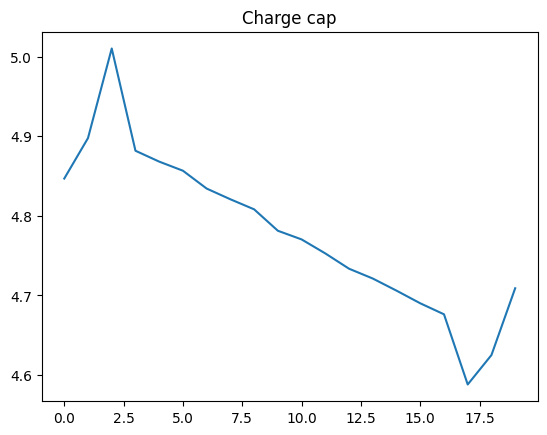

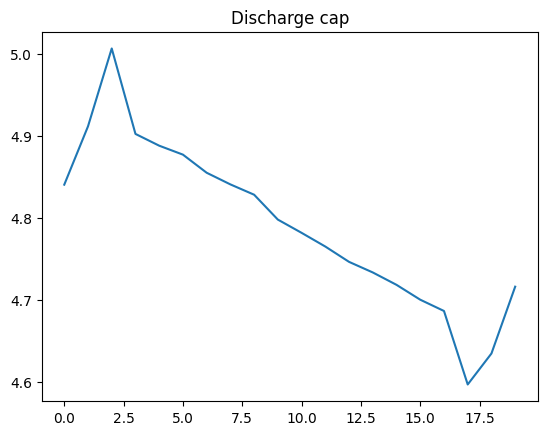

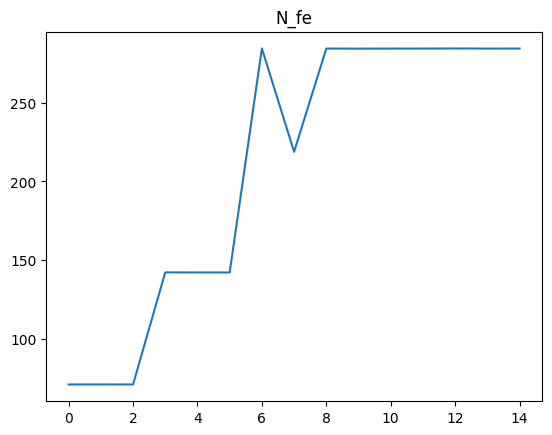

In [5]:
plt.figure()
plt.plot(c.c_ch)
plt.title("Charge cap")

plt.figure()
plt.plot(c.c_dch)
plt.title("Discharge cap")

plt.figure()
plt.plot(c.n_fe)
plt.title("N_fe")

In [20]:
feat.capacity(df)

{'Q_mean': 4.84365316801151,
 'Q_ch': 4.846862473558634,
 'Q_dch': 4.840443862464386,
 'q_ch': array([    0.        ,    24.50451505,    49.00703243,    73.49512097,
           97.99527879,   122.49298659,   146.99550397,   171.49520954,
          195.99563871,   220.49824654,   244.99822346,   269.49575039,
          293.99826776,   318.49570425,   343.01029065,   367.49792718,
          391.9979041 ,   416.50033102,   441.00057929,   465.5152562 ,
          490.00289272,   514.50023877,   539.00275615,   563.51253306,
          588.00016959,   612.49996561,   637.00012343,   661.49991945,
          686.01722738,   710.50558714,   735.00311406,   759.50336233,
          784.0030679 ,   808.51792582,   833.02035273,   857.52296057,
          882.01304709,   906.527905  ,   931.01563193,   955.5155184 ,
          980.01522398,  1004.5152009 ,  1029.0275183 ,  1053.51524524,
         1078.01776261,  1102.51556086,  1127.01553778,  1151.51542425,
         1176.01549162,  1200.51564944,  1

In [33]:
extract_cycling_capacity(DATA_DIR / "Stage_1" / "TP_z01_02")

Num checkups: 15
ET_T10 | 0 | TP_z01_02_01_ET_T10.csv
ET_T23 | 0 | TP_z01_02_01_ET_T23.csv
ET_T45 | 0 | TP_z01_02_01_ET_T45.csv
ZYK | 0 | TP_z01_02_02_ZYK.csv
CU | 1 | TP_z01_02_03_CU.csv
ZYK | 1 | TP_z01_02_04_ZYK.csv
CU | 2 | TP_z01_02_05_CU.csv
ZYK | 2 | TP_z01_02_06_ZYK.csv
CU | 3 | TP_z01_02_07_exCU.csv
ZYK | 3 | TP_z01_02_08_ZYK.csv
CU | 4 | TP_z01_02_09_CU.csv
ZYK | 4 | TP_z01_02_10_ZYK.csv
CU | 5 | TP_z01_02_11_CU.csv
ZYK | 5 | TP_z01_02_12_ZYK.csv
CU | 6 | TP_z01_02_13_CU.csv
ZYK | 6 | TP_z01_02_14_ZYK.csv
CU | 7 | TP_z01_02_15_CU.csv
ZYK | 7 | TP_z01_02_16_ZYK.csv
CU | 8 | TP_z01_02_17_CU.csv
ZYK | 8 | TP_z01_02_18_ZYK.csv
CU | 9 | TP_z01_02_19_exCU.csv
ZYK | 9 | TP_z01_02_20_ZYK.csv
CU | 10 | TP_z01_02_21_CU.csv
ZYK | 10 | TP_z01_02_22_ZYK.csv
CU | 11 | TP_z01_02_23_CU.csv
ZYK | 11 | TP_z01_02_24_ZYK.csv
CU | 12 | TP_z01_02_25_exCU.csv
ZYK | 12 | TP_z01_02_26_ZYK.csv
CU | 13 | TP_z01_02_27_CU.csv
ZYK | 13 | TP_z01_02_28_ZYK.csv
CU | 14 | TP_z01_02_29_CU.csv
ZYK | 14 | TP_z01

In [75]:
def to_cycle_cap_array(caps):
    for cap in caps.values():
        if cap is None:
            continue
        cap.N = len(cap.n_fe) - 1
    N_max = max([cap.N for cap in caps.values() if cap is not None])
    print([cap.N for cap in caps.values() if cap is not None])
    
    dtype = np.dtype([
        ('uid', "U11"),
        ("N", np.int16),
        ("c_charge", np.float32, N_max + 6),
        ("c_discharge", np.float32, N_max + 6),
        ("n_fe", np.float32, N_max + 1),
    ])
    arr = np.full(len(caps), np.nan, dtype=dtype)
    for i, (uid, cap) in enumerate(caps.items()):
        arr[i]['uid'] = uid
        if cap is not None:
            arr[i]['N'] = cap.N
            arr[i]["c_charge"][:cap.N + 6] = cap.c_ch
            arr[i]["c_discharge"][:cap.N + 6] = cap.c_dch
            arr[i]["n_fe"][:cap.N + 1] = cap.n_fe
        else:
            arr[i]["N"] = -1
    return arr
    
            
        

In [76]:
uids = [uid for uid in cycle_capacities.keys()]

In [77]:
cycle_capacities_clean = {uid: cap for uid, cap in cycle_capacities.items() if not uid.endswith("zip_1")}

In [78]:
uids = [uid for uid in cycle_capacities_clean.keys()]

In [79]:
max([len(uid) for uid in uids])

11

In [80]:
arr = to_cycle_cap_array(cycle_capacities_clean)

[11, 11, 15, 15, 15, 15, 15, 15, 15, 15, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 15, 15, 15, 15, 15, 15, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 15, 15, 15]


In [81]:
arr[0]

('TP_z07_03_1', 11, [4.830461 , 4.8668966, 4.990549 , 4.843366 , 4.830764 , 4.819633 , 4.7972126, 4.7817645, 4.7685347, 4.7396245, 4.719655 , 4.697259 , 4.680195 , 4.6650367, 4.5546083, 4.6424894, 4.7255244,       nan,       nan,       nan,       nan], [4.800718 , 4.8782454, 4.984155 , 4.861951 , 4.84772  , 4.836218 , 4.8153486, 4.798378 , 4.785758 , 4.7571297, 4.7354593, 4.712255 , 4.6947618, 4.678117 , 4.570225 , 4.651148 , 4.729097 ,       nan,       nan,       nan,       nan], [ 47.9839,  51.6158,  48.0515,  95.9774,  95.9424,  96.0069, 191.8948, 191.9098, 191.9268, 191.8767, 191.8408, 191.8523,      nan,      nan,      nan,      nan])

In [82]:
bad_cell = [uid for uid, cap in cycle_capacities_clean.items() if cap is None][0]

In [83]:
bad_cell

'TP_z01_02_1'

In [84]:
np.argwhere(arr['uid'] == bad_cell)

array([[3]])

In [85]:
arr['N'][3]

-1

In [87]:
valid = np.sum(arr["N"] != -1)
print(f"{valid} / {len(arr)} cells are valid")


101 / 147 cells are valid


In [88]:
help(np.savez)

Help on function savez in module numpy:

savez(file, *args, **kwds)
    Save several arrays into a single file in uncompressed ``.npz`` format.
    
    Provide arrays as keyword arguments to store them under the
    corresponding name in the output file: ``savez(fn, x=x, y=y)``.
    
    If arrays are specified as positional arguments, i.e., ``savez(fn,
    x, y)``, their names will be `arr_0`, `arr_1`, etc.
    
    Parameters
    ----------
    file : str or file
        Either the filename (string) or an open file (file-like object)
        where the data will be saved. If file is a string or a Path, the
        ``.npz`` extension will be appended to the filename if it is not
        already there.
    args : Arguments, optional
        Arrays to save to the file. Please use keyword arguments (see
        `kwds` below) to assign names to arrays.  Arrays specified as
        args will be named "arr_0", "arr_1", and so on.
    kwds : Keyword arguments, optional
        Arrays to save

In [91]:
np.savez(DATA_DIR / "aging.npz", cycle_capacities=arr)

In [92]:
def load_cycle_cap_array(file):
    f = np.load(file)
    return f["cycle_capacities"]

def to_dictionary(cycle_arr):
    out = {}
    for i, row in enumerate(cycle_arr):
        N = row["N"]
        if N == -1:
            out[row["uid"]] = None
        else:
            out[row['uid']] = CyclingCapacity(
                row["c_charge"][:N + 6],
                row["c_discharge"][:N + 6],
                row["n_fe"][:N + 1],
            )
    return out
    
    

In [93]:
cycle_cap_load = to_dictionary(load_cycle_cap_array(DATA_DIR / "aging.npz"))

In [115]:
def check_equals(a, b):
    assert set(a.keys()) == set(b.keys())
    for k in a.keys():
        if a[k] is None:
            assert b[k] is None
        else:
            for attr in ["c_ch", "c_dch", "n_fe"]:
                arr_a = getattr(a[k], attr)
                arr_b = getattr(b[k], attr)
                assert np.allclose(arr_a, arr_b, equal_nan=True), \
                    f"Disagree on attr {attr}; {arr_a} == {arr_b}"
                    
                

In [116]:
check_equals(cycle_cap_load, cycle_capacities_clean)

(array([12.,  8., 12.,  5., 11., 13.,  8., 19.,  9.,  4.]),
 array([4.68505669, 4.70342779, 4.7217989 , 4.74017   , 4.75854111,
        4.77691221, 4.79528332, 4.81365442, 4.83202553, 4.85039663,
        4.86876774]),
 <BarContainer object of 10 artists>)

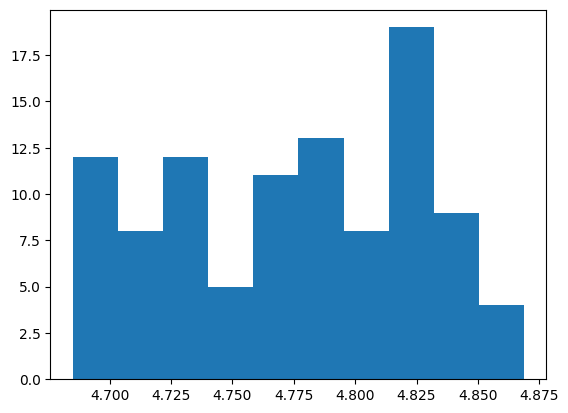

In [67]:
plt.hist(arr["c_charge"][:, 0])

In [51]:
uids

['TP_z07_03_1',
 'TP_z14_02_1',
 'TP_z01_01_1',
 'TP_z01_02_1',
 'TP_z01_03_1',
 'TP_z02_01_1',
 'TP_z02_02_1',
 'TP_z02_03_1',
 'TP_z03_01_1',
 'TP_z03_02_1',
 'TP_z03_03_1',
 'TP_z04_01_1',
 'TP_z04_02_1',
 'TP_z04_03_1',
 'TP_z05_01_1',
 'TP_z05_02_1',
 'TP_z05_03_1',
 'TP_z06_01_1',
 'TP_z06_02_1',
 'TP_z06_03_1',
 'TP_z07_01_1',
 'TP_z07_02_1',
 'TP_z14_03_1',
 'TP_z15_01_1',
 'TP_z15_02_1',
 'TP_z15_03_1',
 'TP_z16_01_1',
 'TP_z16_02_1',
 'TP_z16_03_1',
 'TP_z17_01_1',
 'TP_z17_02_1',
 'TP_z17_03_1',
 'TP_z18_01_1',
 'TP_z18_02_1',
 'TP_z18_03_1',
 'TP_z19_01_1',
 'TP_z19_02_1',
 'TP_z19_03_1',
 'TP_z20_01_1',
 'TP_z20_02_1',
 'TP_z20_03_1',
 'TP_z21_01_1',
 'TP_z21_02_1',
 'TP_z21_03_1',
 'TP_z22_01_1',
 'TP_z22_02_1',
 'TP_z22_03_1',
 'TP_z23_01_1',
 'TP_z23_02_1',
 'TP_z23_03_1',
 'TP_z24_01_1',
 'TP_z24_02_1',
 'TP_z24_03_1',
 'TP_z25_01_1',
 'TP_z25_01.zip_1',
 'TP_z25_02_1',
 'TP_z25_02.zip_1',
 'TP_z25_03_1',
 'TP_z25_03.zip_1',
 'TP_z08_01_1',
 'TP_z08_02_1',
 'TP_z08_03_

In [47]:
arr.dtype

dtype([('uid', '<U'), ('N', '<i2'), ('c_charge', '<f4', (21,)), ('c_discharge', '<f4', (21,)), ('n_fe', '<f4', (16,))])

In [46]:
arr[1]

('', 11, [4.8226657, 4.871254 , 5.001439 , 4.8421764, 4.825766 , 4.8158045, 4.8003783, 4.7910194, 4.7779408, 4.758843 , 4.7328315, 4.7197967, 4.694716 , 4.6785088, 4.5870166, 4.631234 , 4.7017493,       nan,       nan,       nan,       nan], [4.808479 , 4.882224 , 4.9941096, 4.863    , 4.845224 , 4.8352985, 4.8206453, 4.8075094, 4.7926116, 4.7773147, 4.7448626, 4.7301292, 4.7018785, 4.683072 , 4.59297  , 4.6372466, 4.7049627,       nan,       nan,       nan,       nan], [ 52.3248,  56.365 ,  52.3762, 104.5333, 104.4634, 104.4652, 209.0414, 209.0171, 208.9539, 209.0534, 209.0771, 209.0177,      nan,      nan,      nan,      nan])

In [38]:
N_max

15